In [1]:
import numpy as np
import tensorflow as tf
import tqdm, os
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as displayer
import math
#import random

class Config(object):
    pass
config = Config()
config.batch_size = 128
config.learning_rate = 0.02
config.use_float16 = False
config.data_path_dir = "../../../datasets/cifar-100-binary"
config.BN_epsilon = 1e-5
config.BN_decay = 0.995

In [2]:
class Dataset():
    def __init__(self):
        self.x_train, self.y_train = None, None
        self.x_test, self.y_test = None, None
        self.batch_size = config.batch_size
        self.num_classes = 100
        
    def readData(self, path):
        def combineChannels(t, m):
            r = t[:, 2:1026].reshape((m, 1024, 1))
            g = t[:, 1026:2050].reshape((m, 1024, 1))
            b = t[:, 2050:].reshape((m, 1024, 1))
            return np.dstack((r, g, b)).reshape((m, 32, 32, 3))
        
        with open(os.path.join(path, "train.bin"), mode='rb') as file:
            t = np.fromfile(file, dtype = np.uint8).reshape(50000, -1)
            file.close()
            self.y_train = t[:, 1]
            self.x_train = t[:, 2:] /255.0
        
        self.start_batch_index = self.end_batch_index = self.num_train_images = np.shape(self.y_train)[0]
        
        with open(os.path.join(path, "test.bin"), mode='rb') as file:
            t = np.fromfile(file, dtype = np.uint8).reshape(10000, -1)
            self.y_test = t[:, 1]
            self.x_test = t[:,2:] / 255.0
        
    def get_next_batch(self):
        if self.end_batch_index >= self.num_train_images:
            #suffle
            self.suffle()
            self.start_batch_index = 0
            self.end_batch_index = self.batch_size
        
        batch_x = self.x_train[self.start_batch_index : self.end_batch_index].astype(
            np.float16 if config.use_float16 else np.float32)
        batch_y = self.y_train[self.start_batch_index : self.end_batch_index]
        self.start_batch_index = self.end_batch_index
        self.end_batch_index += self.batch_size
        
        return (batch_x, batch_y)
    
    
    def suffle(self, is_training = True):
        if is_training:
            perm = np.random.permutation(self.num_train_images)
            self.x_train = self.x_train[perm]
            self.y_train = self.y_train[perm]
        else:
            perm = np.random.permutation(10000)
            self.x_test = self.x_test[perm]
            self.y_test = self.y_test[perm]
            
            
dataset = Dataset()
dataset.readData(config.data_path_dir)

In [3]:
def batch_norm_wrapper(x, is_training, step):
    """
    is_training: a boolean tensor
    """
    with tf.variable_scope('batch_norm') as scope:
        gamma = tf.Variable(tf.ones([x.get_shape()[-1]]), trainable = False)
        beta  = tf.Variable(tf.zeros([x.get_shape()[-1]]), trainable = False)
        pop_mean = tf.Variable(tf.zeros([x.get_shape()[-1]]), trainable=False, name = "pop_mean")
        pop_var  = tf.Variable(tf.ones([x.get_shape()[-1]]), trainable=False, name = "pop_var")

    def using_batch_statistics():
        batch_mean, batch_var = tf.nn.moments(x,[0])
        train_mean = tf.assign(pop_mean,
                               pop_mean * config.BN_decay + batch_mean * (1 - config.BN_decay))
        train_var = tf.assign(pop_var,
                              pop_var * config.BN_decay + batch_var * (1 - config.BN_decay))
        
#         train_mean = tf.cond(tf.greater(step, 5000), lambda: pop_mean, lambda: batch_mean)
#         train_var = tf.cond(tf.greater(step, 5000), lambda: pop_var, lambda: batch_var)
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(x,
                batch_mean, batch_var, beta, gamma, config.BN_epsilon)

#             return tf.cond(tf.greater(step, 5000), lambda: tf.nn.batch_normalization(x,
#                                                 pop_mean, pop_var, beta, gamma, config.BN_epsilon),
#                                             lambda: tf.nn.batch_normalization(x,
#                                                 pop_mean, pop_var, beta, gamma, config.BN_epsilon))
#         def f1():
#             return tf.nn.batch_normalization(x,
#                 batch_mean, batch_var, beta, gamma, config.BN_epsilon)
#         def f2():
#         tf.cond(tf.greater(step, 5000)
#         inv = tf.rsqrt(tf.add(train_var, 1e-4)) * gamma
#         x * inv + (beta - train_mean * inv)
                       
        
    def using_global_statistics():
        return tf.nn.batch_normalization(x,
            pop_mean, pop_var, beta, gamma, config.BN_epsilon)
    
    return tf.cond(is_training, 
                   using_batch_statistics, 
                   using_global_statistics)

def variable_on_gpu(name, shape, initializer):
    with tf.device('/gpu:0'):
        dtype = tf.float16 if config.use_float16 else tf.float32
        var = tf.get_variable(name, shape, initializer=initializer, dtype=dtype)
    return var

def variable_with_weight_decay(name, shape, stddev, wd):
    dtype = tf.float16 if config.use_float16 else tf.float32
    var = variable_on_gpu(
        name,
        shape,
        tf.truncated_normal_initializer(stddev=stddev, dtype=dtype))
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

layer_sizes = [3*32*32, 100, 100, 100, 100, 100]
# w1_initial = np.random.normal(loc=0, scale=1/layer_sizes[0], 
#                               size = (layer_sizes[0], layer_sizes[1])).astype(np.float32)
# w2_initial = np.random.normal(loc=0, scale=1/layer_sizes[1],
#                               size = (layer_sizes[1], layer_sizes[2])).astype(np.float32)
# w3_initial = np.random.normal(loc=0, scale=1/layer_sizes[2],
#                               size = (layer_sizes[2], layer_sizes[3])).astype(np.float32)
# w4_initial = np.random.normal(loc=0, scale=1/layer_sizes[3], 
#                               size = (layer_sizes[3], layer_sizes[4])).astype(np.float32)
# w5_initial = np.random.normal(loc=0, scale=1/layer_sizes[4], 
#                               size = (layer_sizes[4], layer_sizes[5])).astype(np.float32)


w1_initial = np.random.normal(loc=0, scale=1, 
                              size = (layer_sizes[0], layer_sizes[1])).astype(np.float32)
w2_initial = np.random.normal(loc=0, scale=1,
                              size = (layer_sizes[1], layer_sizes[2])).astype(np.float32)
w3_initial = np.random.normal(loc=0, scale=1,
                              size = (layer_sizes[2], layer_sizes[3])).astype(np.float32)
w4_initial = np.random.normal(loc=0, scale=1, 
                              size = (layer_sizes[3], layer_sizes[4])).astype(np.float32)
w5_initial = np.random.normal(loc=0, scale=1, 
                              size = (layer_sizes[4], layer_sizes[5])).astype(np.float32)

# w1_initial = np.random.rand(layer_sizes[0], layer_sizes[1]).astype(np.float32)
# w2_initial = np.random.rand(layer_sizes[1], layer_sizes[2]).astype(np.float32)
# w3_initial = np.random.rand(layer_sizes[2], layer_sizes[3]).astype(np.float32)
# w4_initial = np.random.rand(layer_sizes[3], layer_sizes[4]).astype(np.float32)
# w5_initial = np.random.rand(layer_sizes[4], layer_sizes[5]).astype(np.float32)

In [4]:
def build_graph(is_using_BN = True):
    # Placeholders
    dtype = tf.float16 if config.use_float16 else tf.float32
    #x = tf.placeholder(dtype, shape=[None, dataset.height, dataset.width, dataset.depth])
    y = tf.placeholder(tf.int32)
    x = tf.placeholder(tf.float32, shape=[None, layer_sizes[0]])
    #y = tf.placeholder(tf.float32, shape=[None, layer_sizes[-1]])
    is_training = tf.placeholder(tf.bool)
    global_step = tf.Variable(0, trainable=False)
    # Layer 1
    #xx = batch_norm_wrapper(x, is_training)
    with tf.variable_scope('layer1') as scope:
        w1 = tf.Variable(w1_initial)
        z1 = tf.matmul(x, w1)
        if is_using_BN:
            z1 = batch_norm_wrapper(z1, is_training, global_step)
            o1 = tf.sigmoid(z1)
        else:
            b1 = tf.Variable(tf.zeros([layer_sizes[1]]))
            z1 = tf.nn.bias_add(z1, b1)
            o1 = tf.sigmoid(z1)
    
    # Layer 2
    with tf.variable_scope('layer2') as scope:
        w2 = tf.Variable(w2_initial)
        z2 = tf.matmul(o1, w2)
        if is_using_BN:
            z2 = batch_norm_wrapper(z2, is_training, global_step)
            o2 = tf.sigmoid(z2)
        else:
            b2 = tf.Variable(tf.zeros([layer_sizes[2]]))
            z2 = tf.nn.bias_add(z2, b2)
            o2 = tf.sigmoid(z2)
    
    # Layer 3
    with tf.variable_scope('layer3') as scope:
        w3 = tf.Variable(w3_initial, name='w3')
        z3 = tf.matmul(o2, w3)
        if is_using_BN:
            z3 = batch_norm_wrapper(z3, is_training, global_step)
            o3 = tf.sigmoid(z3)
        else:
            b3 = tf.Variable(tf.zeros([layer_sizes[3]]))
            z3 = tf.nn.bias_add(z3, b3)
            o3 = tf.sigmoid(z3)
        
    
    # Softmax
#     with tf.variable_scope('layer4') as scope:
#         w4 = tf.Variable(w4_initial, name='w4')
#         z4 = tf.matmul(o3, w4)
#         if is_using_BN:
#             bn4 = batch_norm_wrapper(z4, is_training, global_step)
#             o4 = tf.sigmoid(bn4)
#         else:
#             b4 = tf.Variable(tf.zeros([layer_sizes[4]]))
#             z4 = tf.nn.bias_add(z4, b4)
#             o4 = tf.sigmoid(z4)
        
    with tf.variable_scope('softmax') as scope:
        w5 = tf.Variable(w5_initial)
        b5 = tf.Variable(tf.zeros([layer_sizes[-1]]))
        o5 = y_out = tf.nn.bias_add(tf.matmul(o3, w5), b5)

    # Loss, Optimizer and Predictions
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y, logits=y_out, name='cross_entropy')
    
    tf.add_to_collection('losses', tf.reduce_mean(cross_entropy))
    total_loss = tf.add_n(tf.get_collection('losses'), name='total_loss')
    
#     do1 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, o1)))
#     do2 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, o2)))
#     do3 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, o3)))
#     do4 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, o4)))
    
#     do1 = tf.reduce_mean(tf.multiply(o1, (1 - o1)))
#     do2 = tf.reduce_mean(tf.multiply(o2, (1 - o2)))
#     do3 = tf.reduce_mean(tf.multiply(o3, (1 - o3)))
#     do4 = tf.reduce_mean(tf.multiply(o4, (1 - o4)))
    
    #z1_mean = tf.reduce_mean(tf.abs(z1))
    #batch_var = tf.reduce_mean(tf.get_collection("batch_mean"))
    
    #batch_var = tf.reduce_mean(tf.add_n(batchvar))
    #batch_var = [v.name for v in tf.global_variables()]
#     dw1 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, w1)))
#     dw2 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, w2)))
#     dw3 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, w3)))
#     dw4 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, w4)))
    
#     learning_rate = tf.train.exponential_decay(config.learning_rate, global_step,
#                                            2000, 0.96, staircase=True)


    trainer = tf.train.GradientDescentOptimizer(learning_rate = config.learning_rate).minimize(total_loss, global_step = global_step)

    correct_prediction = tf.equal(tf.cast(tf.arg_max(y_out, 1), tf.int32), y)
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return (x, y, is_training), (z1[:,0], z2[:,0], z3[:,0]), (z1[:,50], z2[:,50], z3[:,50]), trainer, acc, total_loss, y_out, tf.train.Saver()

In [5]:
def train(is_using_BN = True,
          is_continue = False,
          model_name = None,
          current_step = 0,
          max_steps = 200000,
          eval_interval = 500,
          save_interval = 50000):
    
    graph = tf.Graph()
    with graph.as_default():
        (x_train, y_train, is_training), (Do1, Do2, Do3), (Dw1, Dw2, Dw3), trainer, accuracy, loss, y_out, saver = \
        build_graph(is_using_BN)
    
    
    if is_continue:
        """load something"""
        f = open(os.path.join(config.store_path, "losses.bin"), "rb")
        losses = np.fromfile(f, dtype = np.float32)
        f.close()
        f = open(os.path.join(config.store_path, "train_acc.bin"), "rb")
        train_acc = np.fromfile(f, dtype = np.float32)
        f.close()
        f = open(os.path.join(config.store_path, "test_acc.bin"), "rb")
        test_acc = np.fromfile(f, dtype = np.float32)
        f.close()
    else:
        losses, train_acc, test_acc = np.array([], dtype = np.float32), np.array([], dtype = np.float32), np.array([], dtype = np.float32)
        do1s, do2s, do3s, do4s = np.array([], dtype = np.float32), np.array([], dtype = np.float32), np.array([], dtype = np.float32), np.array([], dtype = np.float32)
        dw1s, dw2s, dw3s, dw4s = np.array([], dtype = np.float32), np.array([], dtype = np.float32), np.array([], dtype = np.float32), np.array([], dtype = np.float32)
    
    def evaluate(sess, num_examples = 5000, is_on_training_set = True): 
        accs = []
        if is_on_training_set:
            prem = np.random.permutation(dataset.num_train_images)
            x = dataset.x_train[prem[:num_examples]]
            y = dataset.y_train[prem[:num_examples]]
        else:
            x = dataset.x_test[:num_examples]
            y = dataset.y_test[:num_examples]
        
        for i in range(0, num_examples, 500):
            res = sess.run([accuracy],
                           feed_dict = {x_train: x[i : i + 500],
                                        y_train: y[i : i + 500], 
                                        is_training: False})
            accs.append(res[0])
        
        return sum(accs) / len(accs)
 
    def save(arr, name):
        f = open(os.path.join(config.store_path, name), "wb")
        arr.tofile(f)
        f.close()
        
    with tf.Session(graph = graph) as sess:
        if is_continue:
            if model_name is None:
                raise ValueError('Need the name of model')
            saver = tf.train.import_meta_graph(os.path.join(config.store_path, model_name + '.meta'))
            saver.restore(sess, os.path.join(config.store_path, model_name))
        else:
            sess.run(tf.global_variables_initializer())
            
        # -----------------------------------------------------------------------------------------
        # training
        for i in tqdm.tqdm(range(current_step + 1, max_steps + 1)):
            batch = dataset.get_next_batch()
            _,l,(do1,do2,do3),(dw1,dw2,dw3) = sess.run([trainer, loss, (Do1, Do2, Do3), (Dw1, Dw2, Dw3)], 
                                   feed_dict = {x_train : batch[0],
                                             y_train : batch[1],
                                             is_training : True})
            #losses.append(l)
#             popvar_FC1.append(pvfc1)
#             popmean_FC1.append(pmfc1)
            if i % save_interval == 0:
                saved_model = saver.save(sess, config.store_path + 'model.ckpt', i)
                save(do1s, 'do1.bin')
                save(do2s, 'do2.bin')
                save(do3s, 'do3.bin')
                #save(do4s, 'do4.bin')
                save(dw1s, 'dw1.bin')
                save(dw2s, 'dw2.bin')
                save(dw3s, 'dw3.bin')
                #save(dw4s, 'dw4.bin')
                save(losses, "losses.bin")
                save(train_acc, "train_acc.bin")
                save(test_acc, "test_acc.bin")
                
            
            if i % eval_interval == 0:
                do1s=np.append(do1s, do1)
                do2s=np.append(do2s, do2)
                do3s=np.append(do3s, do3)
                #do4s=np.append(do4s, do4)
                dw1s=np.append(dw1s, dw1)
                dw2s=np.append(dw2s, dw2)
                dw3s=np.append(dw3s, dw3)
                #dw4s=np.append(dw4s, dw4)
#                
                losses = np.append(losses, l)
                test_acc = np.append(test_acc, evaluate(sess, 10000, False)).astype(np.float32)
                train_acc = np.append(train_acc, evaluate(sess)).astype(np.float32)
                
                
                displayer.clear_output()
#                 print (np.mean(np.abs(dw1)))
#                 print (np.mean(np.abs(dw4)))
                print('test acc: ', test_acc[-1])
                print('train acc: ', train_acc[-1])
                #print(dw1, dw2, dw3, dw4)
                #print(do1, do2, do3, do4)
                plt.figure(1)
                plt.plot(range(0, i, eval_interval), train_acc, 'red', range(0, i, eval_interval), test_acc, 'blue')
                plt.figure(2)
                plt.plot(range(0, i, eval_interval), losses)
#                 ax1 = plt.subplot(111)
#                 #plt.plot(np.arange(0, i, eval_interval), losses)
#                 #plt.figure(1)
#                 ax1.plot(range(0, i, eval_interval), train_acc, 'red', range(0, i, eval_interval), test_acc, 'blue')
#                 plt.figure(2)
#                 plt.plot(np.arange(0, i), popvar_FC1)
#                 plt.figure(3)
#                 plt.plot(np.arange(0, i), popmean_FC1)
                plt.show()
                
        
    return losses, train_acc, test_acc

test acc:  0.0968
train acc:  0.0986


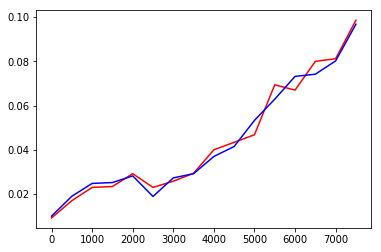

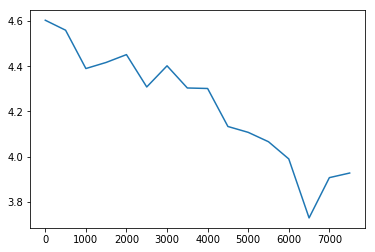

  4%|██▏                                                    | 8169/200000 [01:10<21:40, 147.50it/s]

In [ ]:
config.learning_rate = 2.0
config.store_path = "../../../models/MLP/cifar100/withoutBN/lr 2.0"
losses, train_acc, test_acc = train(is_using_BN = False)

In [ ]:
config.learning_rate = 1.0
config.store_path = "../../../models/MLP/cifar100/withBN/lr 1.0"
losses, train_acc, test_acc = train(is_using_BN = True)

test acc:  0.1506
train acc:  0.4856


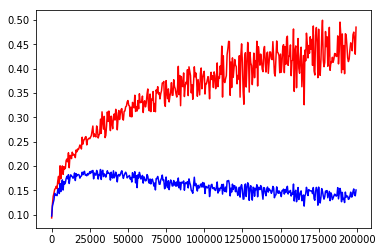

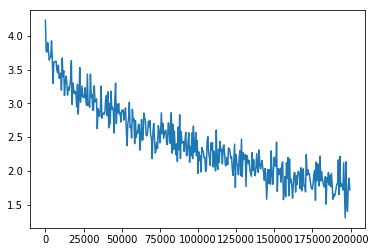

100%|██████████████████████████████████████████████████████| 200000/200000 [36:57<00:00, 90.21it/s]


In [6]:
config.learning_rate = 2.0
config.store_path = "../../../models/MLP/cifar100/withBN/lr 2.0"
losses, train_acc, test_acc = train(is_using_BN = True)

test acc:  0.1608
1.19833 4.63391 7.69657
0.000697549 0.00152571 0.0016177


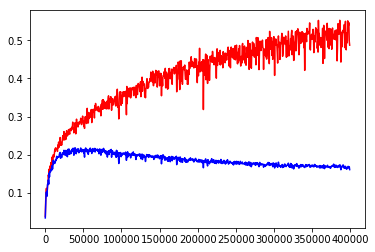

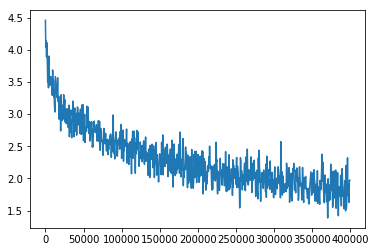

100%|████████████████████████████████████████████████████| 400000/400000 [1:16:27<00:00, 87.20it/s]


In [6]:
config.learning_rate = 2.0
config.store_path = "../../../models/MLP/cifar100/withBN/lr 2.0"
losses, train_acc, test_acc = train(is_using_BN = True)

test acc:  0.1465
2.73975 5.13061 4.5474
0.000334419 0.000514953 0.000428704


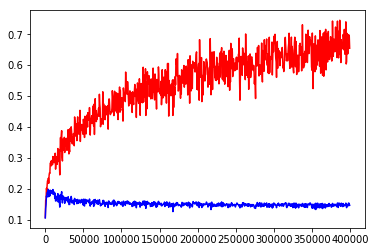

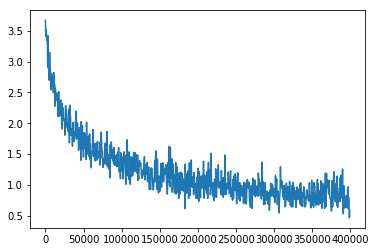

100%|████████████████████████████████████████████████████| 400000/400000 [1:30:41<00:00, 73.50it/s]


In [7]:
config.learning_rate = 10.0
config.store_path = "../../../models/MLP/cifar100/withBN/lr 10.0"
losses, train_acc, test_acc = train(is_using_BN = True)